# Problem Set 5
#### Cameron Smith

In [1]:
!pip install daft==0.1.2
import csv
import urllib.request as request
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import ListedColormap
from matplotlib import rc
import daft
from scipy.optimize import check_grad
import torch
np.random.seed(2)
torch.manual_seed(0)

## Question 1

First, let's get the data:

In [2]:
url = "http://astrowizici.st/teaching/phs5000/ps5_data.csv"
response = request.urlopen(url)
lines = [l.decode('utf-8') for l in response.readlines()]
cr = csv.reader(lines)
cr_data = list(cr)
data = np.array(cr_data[1:])
data = data.astype(np.float)

Get each column of data

In [3]:
x_1, x_2, classification = data.T

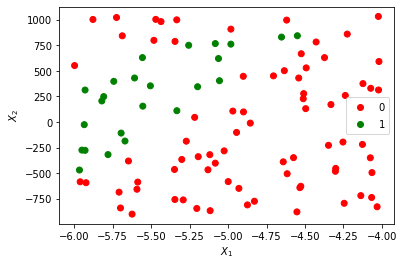

In [4]:
cmap=ListedColormap(['r', 'g'])
scatter = plt.scatter(x_1, x_2, c=classification, cmap=cmap)
plt.xlabel(r"$X_1$")
plt.ylabel(r"$X_2$")
plt.legend(*scatter.legend_elements(num=1))
plt.show()

Now we draw our network

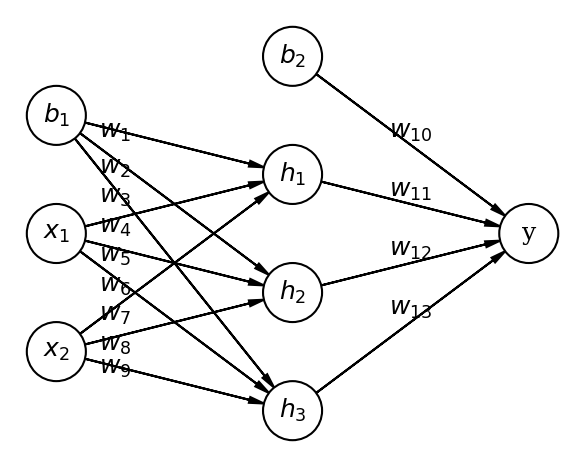

In [5]:
rc("font", family="serif", size=12)
rc("text", usetex=False)

pgm = daft.PGM(dpi=150)

pgm.add_node('b1', r"$b_1$", 0, 3)
pgm.add_node('x1', r"$x_1$", 0, 2)
pgm.add_node('x2', r"$x_2$", 0, 1)


pgm.add_node('b2', r"$b_2$", 2, 3.5)
pgm.add_node('h1', r"$h_1$", 2, 2.5)
pgm.add_node('h2', r"$h_2$", 2, 1.5)
pgm.add_node('h3', r"$h_3$", 2, 0.5)

pgm.add_node('c', r"y", 4, 2)

# edges
pgm.add_edge("b1", "h1", label=r'$w_1$', xoffset=-1)
pgm.add_edge("x1", "h1", label=r'$w_4$', xoffset=-1, yoffset=-0.5)
pgm.add_edge("x2", "h1", label=r'$w_7$', xoffset=-1,  yoffset=-1)

pgm.add_edge("b1", "h2", label=r'$w_2$', xoffset=-1, yoffset=0.5)
pgm.add_edge("x1", "h2", label=r'$w_5$', xoffset=-1, yoffset=0)
pgm.add_edge("x2", "h2", label=r'$w_8$', xoffset=-1, yoffset=-0.5)

pgm.add_edge("b1", "h3", label=r'$w_3$', xoffset=-1, yoffset=1)
pgm.add_edge("x1", "h3", label=r'$w_6$', xoffset=-1, yoffset=0.5)
pgm.add_edge("x2", "h3", label=r'$w_9$', xoffset=-1)

pgm.add_edge("b2", "c", label=r'$w_{10}$')
pgm.add_edge("h1", "c", label=r'$w_{11}$')
pgm.add_edge("h2", "c", label=r'$w_{12}$')
pgm.add_edge("h3", "c", label=r'$w_{13}$')

pgm.render();

Where $b_1 = b_2 = 1$ and sigmoid activation is used for each neuron.

We have the loss function:
$$
E = \frac{1}{2}\sum_{i}^{N}(y_i - y_{\textrm{pred},i})^2
$$

We therefore have:
$$
y_{\textrm{pred},i} = f(\alpha_4)
$$
where
$$
\alpha_4 = w_{10}b_2 + w_{11}h_1 + w_{12}h_2 + w_{13}h_3 \\
\quad = w_{10} + w_{11}h_1 + w_{12}h_2 + w_{13}h_3 \, ,
$$

with,
$$
h_1 = f(\alpha_1) \, ,\\
h_2 = f(\alpha_2) \, ,\\
h_3 = f(\alpha_3) \, ,\\
$$
where
$$ 
\alpha_1 = w_1 + x_1 w_4 + x_2 w_7 \, ,\\
\qquad \alpha_2 = w_2 + x_1 w_5 + x_2 w_8 \, \text{, and}\\
\alpha_3 = w_3 + x_1 w_6 + x_2 w_9 \, ,\\
$$

where
$$
f(x) = \frac{1}{1 + e^{-x}}
$$
Is the sigmoid activation function.

To update our weights we take a step of length $\eta$ in parameter space in the direction of the negative gradient, i.e
$$
\mathbf{w}^{(t+1)} = \mathbf{w}^{(t)} - \eta\frac{\partial{}E}{\partial{}\mathbf{w}} \quad ,
$$
where
$$
\mathbf{w} = (w_1, w_2, ..., w_{13})
$$
Is our vector of weights. We therefore need to calculate the gradient
$$
 \frac{\partial{}E}{\partial{}\mathbf{w}} = \left(\frac{\partial{}E}{\partial{}w_1}, \frac{\partial{}E}{\partial{}w_2}, ..., \frac{\partial{}E}{\partial{}w_{13}} \right)
$$

We have:
$$
\frac{\partial{}E}{\partial{}{w_1}} = \frac{\partial{}E}{\partial{}{y_{\textrm{pred}}}} \frac{\partial{}y_{\textrm{pred}}}{\partial{}{\alpha_4}}\frac{\partial{}\alpha_4}{\partial{}{h_1}}\frac{\partial{}h_1}{\partial{}{\alpha_1}}\frac{\partial{}\alpha}{\partial{}{w_1}} \\
= \left[-(y-y_{\textrm{pred}}) \right]\left[ y_{\textrm{pred}}(1-y_{\textrm{pred}})\right]\left[w_{11} \right]\left[ h_1(1-h_1)\right]\left[ 1\right] \\
= -(y-y_{\textrm{pred}})y_{\textrm{pred}}(1-y_{\textrm{pred}}) w_{11} h_1(1-h_1)
$$

Similarly, we have:
$$
\frac{\partial{}E}{\partial{}{w_2}} = -(y-y_{\textrm{pred}})y_{\textrm{pred}}(1-y_{\textrm{pred}}) w_{12} h_2(1-h_2) \\
\frac{\partial{}E}{\partial{}{w_3}} = -(y-y_{\textrm{pred}})y_{\textrm{pred}}(1-y_{\textrm{pred}}) w_{13} h_3(1-h_3) \\
\frac{\partial{}E}{\partial{}{w_4}} = -(y-y_{\textrm{pred}})y_{\textrm{pred}}(1-y_{\textrm{pred}}) w_{11} h_1(1-h_1)x_1 \\
\frac{\partial{}E}{\partial{}{w_5}} = -(y-y_{\textrm{pred}})y_{\textrm{pred}}(1-y_{\textrm{pred}}) w_{12} h_2(1-h_2)x_1 \\
\frac{\partial{}E}{\partial{}{w_6}} = -(y-y_{\textrm{pred}})y_{\textrm{pred}}(1-y_{\textrm{pred}}) w_{13} h_3(1-h_3)x_1 \\
\frac{\partial{}E}{\partial{}{w_7}} = -(y-y_{\textrm{pred}})y_{\textrm{pred}}(1-y_{\textrm{pred}}) w_{11} h_1(1-h_1)x_2 \\
\frac{\partial{}E}{\partial{}{w_8}} = -(y-y_{\textrm{pred}})y_{\textrm{pred}}(1-y_{\textrm{pred}}) w_{12} h_2(1-h_2)x_2 \\
\frac{\partial{}E}{\partial{}{w_9}} = -(y-y_{\textrm{pred}})y_{\textrm{pred}}(1-y_{\textrm{pred}}) w_{13} h_3(1-h_3)x_2 \\
\frac{\partial{}E}{\partial{}{w_{10}}} = -(y-y_{\textrm{pred}})y_{\textrm{pred}}(1-y_{\textrm{pred}}) \\
\frac{\partial{}E}{\partial{}{w_{11}}} = -(y-y_{\textrm{pred}})y_{\textrm{pred}}(1-y_{\textrm{pred}}) h_1 \\
\frac{\partial{}E}{\partial{}{w_{12}}} = -(y-y_{\textrm{pred}})y_{\textrm{pred}}(1-y_{\textrm{pred}}) h_2\\
\frac{\partial{}E}{\partial{}{w_{13}}} = -(y-y_{\textrm{pred}})y_{\textrm{pred}}(1-y_{\textrm{pred}})h_3 \\
$$

Now we can update the weights using:
$$
\mathbf{w}^{(t+1)} = \mathbf{w}^{(t)} - \eta\frac{\partial{}E}{\partial{}\mathbf{w}} \quad .
$$

## Question 2

First, let's get the  data and split into training and testing sets. We chose a data split of 80 (training)/20 (testing). This leaves the majority of the data for training - making the training better, while still leaving enough to be confident in our testing.

In [6]:
# put data into X and classifications into Y
X = np.stack((x_1, x_2)).T
y = classification.reshape((-1, 1))

# normalise data to avoid saturation or dead neurons
X_mean, X_std = (np.mean(X, axis=0), np.std(X, axis=0))
x = (X - X_mean) / X_std

# split into training and test sets:
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)


# get sizes
N, D_in = x_train.shape
N, D_out = y_train.shape
N_test, _ = x_test.shape

H = 3

# activation function
sigmoid = lambda x: 1/(1 + np.exp(-x))

we want to avoid saturation, or zeroed-out neurons. Since our data is (now) zero centered and unit variance, we initialise our weights as:
$$
w \sim \mathcal{N}\left(0, 1\right) \quad .
$$

In [7]:
# Weights for the bias terms in the hidden layer:
w1, w2, w3 = np.random.randn(H) 
# Weights for x1 to all neurons.
w4, w5, w6 = np.random.randn(H)
# Weights for x2 to all neurons.
w7, w8, w9 = np.random.randn(H)
# Weights for hidden layer outputs to output neuron.
w10, w11, w12, w13 = np.random.randn(H + 1)

Let's now define our network:

In [8]:
def forward_pass(x, w, N):
  w1, w2, w3, w4, w5, w6, w7, w8, w9, w10, w11, w12, w13 = w
  # Hidden layer.
  hidden_layer_inputs = np.hstack([
      np.ones((N, 1)),
      x
  ])
  hidden_layer_weights = np.array([
      [ w1,  w2,  w3],
      [ w4,  w5,  w6],
      [ w7,  w8,  w9]
  ])


  alpha_h = hidden_layer_inputs @ hidden_layer_weights
  h = sigmoid(alpha_h)

  # Output layer.
  output_layer_inputs = np.hstack([
      np.ones((N, 1)),
      h
  ])
  output_layer_weights = np.array([
      [w10, w11, w12, w13]
  ]).T

  alpha_4 = output_layer_inputs @ output_layer_weights
  y_pred = sigmoid(alpha_4)

  return h, y_pred

Now make a prediction, and calculate loss:

In [9]:
w = np.array([
              w1, w2, w3, w4, w5, w6, w7,
              w8, w9, w10, w11, w12, w13
])
# test training set
h, y_pred = forward_pass(x_train, w, N)
loss = 0.5 * np.sum((y_pred - y_train)**2)
print(f"Initial loss (training set): {loss:.1e}")

# test test set
h, y_pred = forward_pass(x_test, w, N_test)
loss = 0.5 * np.sum((y_pred - y_test)**2)
print(f"Initial loss (test set): {loss:.1e}")

Initial loss (training set): 1.6e+01
Initial loss (test set): 4.2e+00


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in exp


To improve this, we optimise through back propogation:

In [10]:
def back_prop(x, y, y_pred, w, h, eta):
  w1, w2, w3, w4, w5, w6, w7, w8, w9, w10, w11, w12, w13 = w.flatten()
  x1, x2 = x.T
  h1, h2, h3 = h.T
  
  # dE/dAlpha
  s = -(y - y_pred) * y_pred * (1- y_pred)
  s = s.flatten()
  dE_dw13 = s * h3
  dE_dw12 = s * h2
  dE_dw11 = s * h1
  dE_dw10 = s
  dE_dw9  = s * w13 * h3 * (1-h3) * x2
  dE_dw8  = s * w12 * h2 * (1-h2) * x2
  dE_dw7  = s * w11 * h1 * (1-h1) * x2
  dE_dw6  = s * w13 * h3 * (1-h3) * x1
  dE_dw5  = s * w12 * h2 * (1-h2) * x1
  dE_dw4  = s * w11 * h1 * (1-h1) * x1
  dE_dw3  = s * w13 * h3 * (1-h3)
  dE_dw2  = s * w12 * h2 * (1-h2)
  dE_dw1  = s * w11 * h1 * (1-h1)

  grad_w = np.array([
    dE_dw1, dE_dw2, dE_dw3, dE_dw4, dE_dw5, dE_dw6, dE_dw7,
    dE_dw8, dE_dw9, dE_dw10, dE_dw11, dE_dw12, dE_dw13, 
  ])
  
  grad_w = np.sum(grad_w, axis=-1)

  w_new = w - eta * grad_w

  return w_new

first, let's check our derivatives

In [11]:
def f(p):
  w1, w2, w3, w4, w5, w6, w7, w8, w9, w10, w11, w12, w13 = p
  # Hidden layer.
  hidden_layer_inputs = np.hstack([
      np.ones((N, 1)),
      x_train
  ])
  hidden_layer_weights = np.array([
      [ w1,  w2,  w3],
      [ w4,  w5,  w6],
      [ w7,  w8,  w9]
  ])


  alpha_h = hidden_layer_inputs @ hidden_layer_weights
  h = sigmoid(alpha_h)

  # Output layer.
  output_layer_inputs = np.hstack([
      np.ones((N, 1)),
      h
  ])
  output_layer_weights = np.array([
      [w10, w11, w12, w13]
  ]).T

  alpha_4 = output_layer_inputs @ output_layer_weights
  y_pred = sigmoid(alpha_4)

  return 0.5 * np.sum((y_pred - y_train)**2)

def g(p):
  w1, w2, w3, w4, w5, w6, w7, w8, w9, w10, w11, w12, w13 = p
  # Hidden layer.
  hidden_layer_inputs = np.hstack([
      np.ones((N, 1)),
      x_train
  ])
  hidden_layer_weights = np.array([
      [ w1,  w2,  w3],
      [ w4,  w5,  w6],
      [ w7,  w8,  w9]
  ])


  alpha_h = hidden_layer_inputs @ hidden_layer_weights
  h = sigmoid(alpha_h)

  # Output layer.
  output_layer_inputs = np.hstack([
      np.ones((N, 1)),
      h
  ])
  output_layer_weights = np.array([
      [w10, w11, w12, w13]
  ]).T

  alpha_4 = output_layer_inputs @ output_layer_weights
  y_pred = sigmoid(alpha_4)

  w1, w2, w3, w4, w5, w6, w7, w8, w9, w10, w11, w12, w13 = p
  x1, x2 = x_train.T
  h1, h2, h3 = h.T
  
  # dE/dAlpha
  s = -(y_train - y_pred) * y_pred * (1- y_pred)
  s = s.flatten()
  # derivatives
  dE_dw13 = s * h3
  dE_dw12 = s * h2
  dE_dw11 = s * h1
  dE_dw10 = s
  dE_dw9  = s * w13 * h3 * (1-h3) * x2
  dE_dw8  = s * w12 * h2 * (1-h2) * x2
  dE_dw7  = s * w11 * h1 * (1-h1) * x2
  dE_dw6  = s * w13 * h3 * (1-h3) * x1
  dE_dw5  = s * w12 * h2 * (1-h2) * x1
  dE_dw4  = s * w11 * h1 * (1-h1) * x1
  dE_dw3  = s * w13 * h3 * (1-h3)
  dE_dw2  = s * w12 * h2 * (1-h2)
  dE_dw1  = s * w11 * h1 * (1-h1)

  grad_w = np.array([
    dE_dw1, dE_dw2, dE_dw3, dE_dw4, dE_dw5, dE_dw6, dE_dw7,
    dE_dw8, dE_dw9, dE_dw10, dE_dw11, dE_dw12, dE_dw13, 
  ])
  
  grad_w = np.sum(grad_w, axis=-1).reshape((-1, 1))

  return grad_w.flatten()

In [12]:
check_grad(f, g, np.random.normal(size=13))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in exp


8.523521138177826e-06

So it looks reasonable, error is less than $10^{-5}$.

We now train our network. I've choosen to train for $10^5$ epochs with a learning rate of $\eta = 10^{-4}$. Since our network is very small, we should still be able to get through training fast - even with $10^5$ epochs. Since we have so many epochs, even with a small learning rate we will still be able to traverse adequate distance in parameter space (considering also that we have a very small network) while hopefully avoiding 'over-shooting' a minima in the loss function.

In [13]:
num_epochs = 100000
train_losses = np.empty(num_epochs)
test_losses = np.empty(num_epochs)

eta = 1e-4
for epoch in range(num_epochs):
    # forward pass
    h, y_pred_train = forward_pass(x_train, w, N)
    _, y_pred_test = forward_pass(x_test, w, N_test)

    # loss
    train_loss = 0.5 * np.sum((y_pred_train - y_train)**2)
    test_loss = 0.5 * np.sum((y_pred_test - y_test)**2)



    # updates
    if not epoch % 1000:
        print(f"\rEpoch: {epoch: >5}, Training loss: {train_loss:3.1e}, Test loss: {test_loss:3.1e}", end='')
    train_losses[epoch] = train_loss
    test_losses[epoch] = test_loss

    # back prop
    w = back_prop(x_train, y_train, y_pred_train, w, h, eta)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in exp


Epoch: 99000, Training loss: 6.7e+00, Test loss: 1.9e+00

Plotting the loss, we get the following:

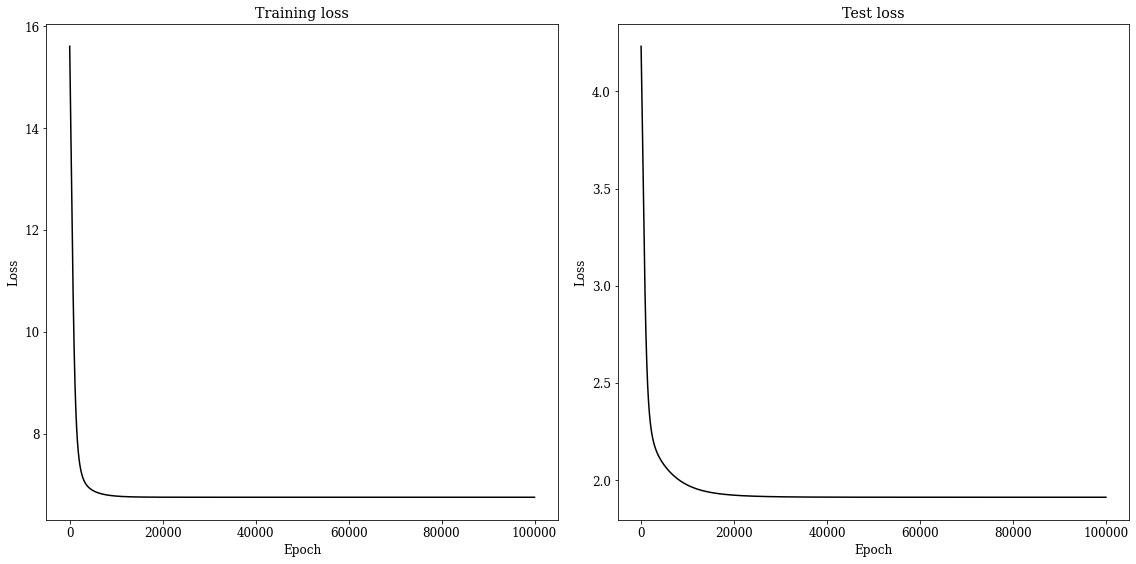

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

for i, ax in enumerate(axs):
  if i ==0:
    losses = train_losses
    title = "Training loss"
  else:
    losses = test_losses
    title = "Test loss"
  ax.plot(losses, c='k')
  ax.set_xlabel("Epoch")
  ax.set_ylabel("Loss")
  ax.set_title(title)
  ax.xaxis.set_major_locator(MaxNLocator(6))
  ax.yaxis.set_major_locator(MaxNLocator(6))
fig.tight_layout()

## Question 3

We now implement the same model using pytorch:

In [15]:
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Construct the model.
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.Sigmoid(),
    torch.nn.Linear(H, D_out),
    torch.nn.Sigmoid(),
)

loss_fn = torch.nn.MSELoss(reduction='sum')

epochs = 100000
learning_rate = 1e-4

train_losses = np.empty(epochs)
test_losses = np.empty(epochs)
for t in range(epochs):
    # Forward pass.
    y_pred = model(x_train)
    y_pred_test = model(x_test)

    # Compute loss.
    train_loss = loss_fn(y_pred, y_train)
    test_loss = loss_fn(y_pred_test, y_test)
    if t % 100 == 99:
        print(f"\rEpoch: {t: >5}, Training loss: {train_loss.item():3.1e}, Test loss: {test_loss.item():3.1e}", end='')
    train_losses[t] = train_loss.item()
    test_losses[t] = test_loss.item()


    # Zero the gradients before running the backward pass.
    model.zero_grad()

    # Backward pass.
    train_loss.backward()

    # Update the weights using gradient descent.
    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad

Epoch: 99999, Training loss: 1.4e+01, Test loss: 3.8e+00

Plotting the losses, we get the following:

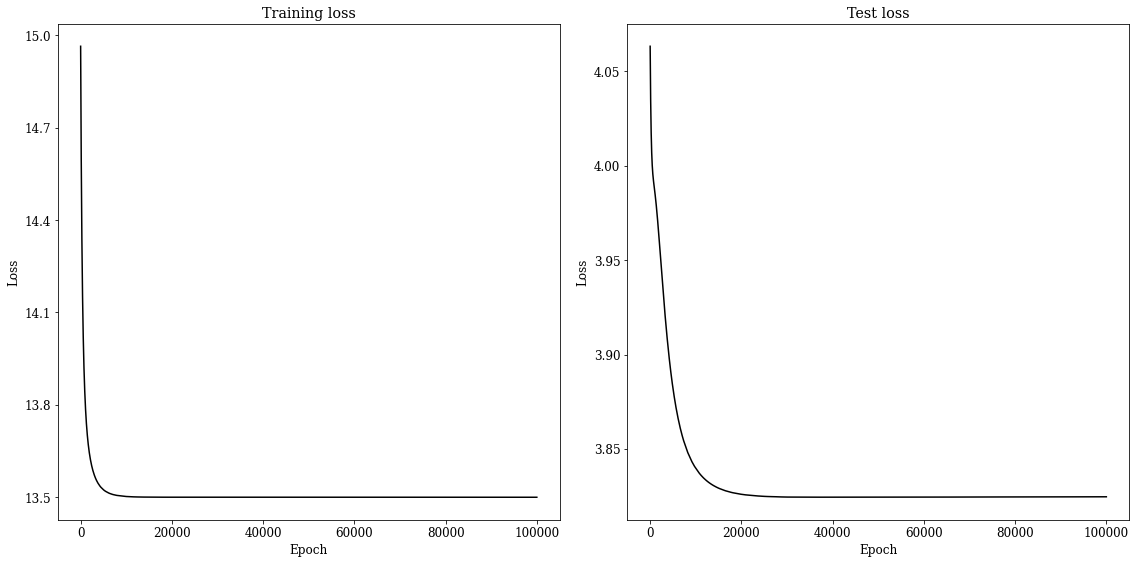

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

for i, ax in enumerate(axs):
  if i ==0:
    losses = train_losses
    title = "Training loss"
  else:
    losses = test_losses
    title = "Test loss"
  ax.plot(losses, c='k')
  ax.set_xlabel("Epoch")
  ax.set_ylabel("Loss")
  ax.set_title(title)
  ax.xaxis.set_major_locator(MaxNLocator(6))
  ax.yaxis.set_major_locator(MaxNLocator(6))
fig.tight_layout()

## Question 4

> 1. The training loss is decreasing with epoch but the test loss is unchanged, maybe even increasing.



It is likely that the model is 'overfitting' the data. To resolve this either simplify your model - less neurons/less layers, get more data or use dropout or some other regularisation.

> 2. The training loss is decreasing, but so slowly that it is going to take a lifetime to train!

Most likely the learning rate is too small (if the network is just running slow, it is also possible that the model is either too large, i.e. too many neurons, or the batch size is too large). Therefore you should try (probably in this order) to 1. increase the learning rate, 2. decrease the batch size, 3. decrease the size of the model.

> 3. The training and test loss is increasing!

It is likely that the learning rate is too high and we cant 'desend' to a lower loss. In this case simply set a lower learning rate.

> 4. I've run for 1,000 epochs and the training loss is exactly the same as it was in the first epoch.

This could be caused by zeroed out neurons or over saturated neurons. In either case you should inspect the weight initialisations (maybe see [this](http://astrowizici.st/teaching/phs5000/14/) for some hints).

> 5. The training loss has decreased, and the test loss has decreased, but the test loss has not decreased as much as the training loss. Is there something I could do to improve the network predictions in a generalised way so it performs better on unseen data?

Get more data - either literally or artificially through data augmentation. In the case of a convolutional neural network, this could be done by flipping images (left to right, up to down), inverting the colour scheme of the image, adding noise (without distortion), or rotating them (be careful, as rotation by an arbitrary angle could cause the network to learn the resulting interpolation artifacts).